# Comparing _autodifferentiation_ & _finite differences_ in Metacalibration

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import autometacal as amc

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
##Local settings
import time
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import galsim
import tensorflow as tf

import tqdm

## Generate Data

In [4]:
import tensorflow_addons as tfa
tfa.__version__

'0.16.0-dev'

In [5]:
seed = 31415
rng = np.random.RandomState(seed)

In [6]:
snr= 200
scale = 0.2
stamp_size = 51
psf_fwhm = 0.9
gal_hlr = 0.7

In [7]:
def make_data(N=1,
  snr = 80,
  scale = 0.263,
  stamp_size = 51,
  psf_fwhm = 0.9,
  gal_hlr = 0.7,
  gal_g1 = [0],
  gal_g2 = [0]):
  
  gal_list = []
  psf_list = []
  
  for n in range(N):
    psf = galsim.Kolmogorov(fwhm=psf_fwhm).withFlux(1.0)

    obj0 = galsim.Exponential(half_light_radius=gal_hlr).shear(g1=gal_g1[n],g2=gal_g2[n])
    obj = galsim.Convolve(psf, obj0)

    psf_image = psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale)
    gal_image = obj.drawImage(nx=stamp_size, ny=stamp_size, scale=scale)
    noise = galsim.GaussianNoise()
    gal_image.addNoiseSNR(noise,snr)
    gal_image = tf.convert_to_tensor(gal_image.array)
    psf_image = tf.convert_to_tensor(psf_image.array)
    gal_list.append(gal_image)
    psf_list.append(psf_image)
    del gal_image
    del psf_image
  gal_image_stack = tf.stack(gal_list)
  psf_image_stack = tf.stack(psf_list)
  return gal_image_stack, psf_image_stack

In [8]:
gal_images, psf_images = make_data(N=1,
                                  snr = snr,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm,
                                  gal_hlr = gal_hlr,
                                  gal_g1 = [0.0,.01,-0.01],gal_g2=[0.0,.0,.01])

Text(0.5, 1.0, 'psf model')

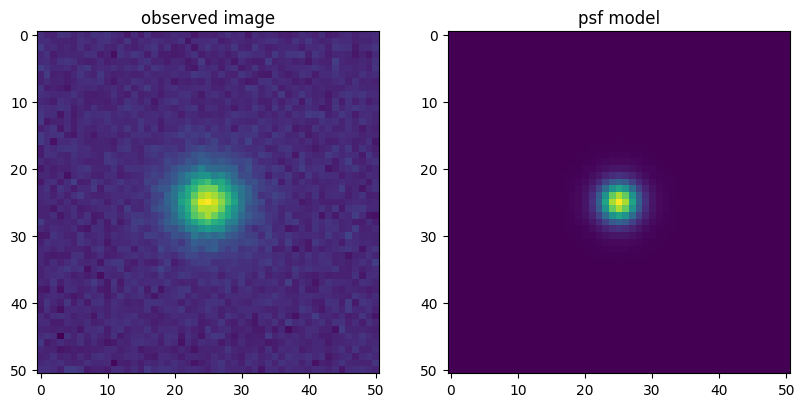

In [9]:
style.use('default')
figure(figsize=(15,5))
subplot(131)
imshow(gal_images[0]); title('observed image')
subplot(132)
imshow(psf_images[0]); title('psf model')


## Generate a 20% larger PSF for reconvolution.

In [10]:
reconv_psf = galsim.Moffat(beta=2.5, 
                    fwhm=psf_fwhm*1.2)
reconv_psf_image = tf.expand_dims(tf.convert_to_tensor(reconv_psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array),axis=0)

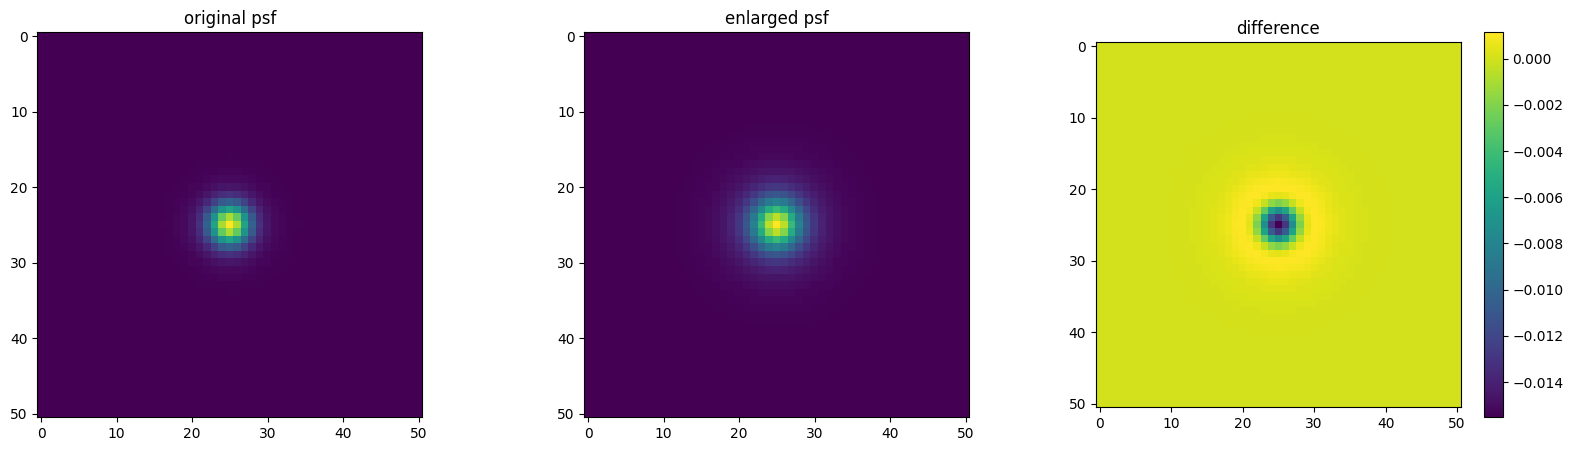

In [11]:
style.use('default')
figure(figsize=(20,5))
subplot(131)
imshow(psf_images[0]); title('original psf')
subplot(132)
imshow(reconv_psf_image[0]); title('enlarged psf')
subplot(133)
imshow(reconv_psf_image[0] - psf_images[0]); title('difference');colorbar()

## Test GalFlow Deconv/Reconv

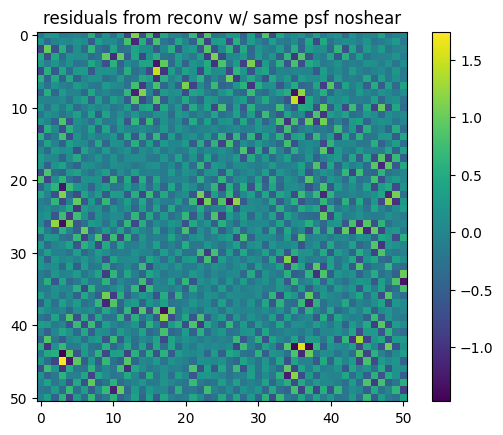

In [12]:
style.use('default')
imshow(amc.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images[tf.newaxis,0],
                                       psf_images[tf.newaxis,0],[[0.0,0.0]])[0]-gal_images[0]);title('residuals from reconv w/ same psf noshear');colorbar()


## GalFlow vs GalSim

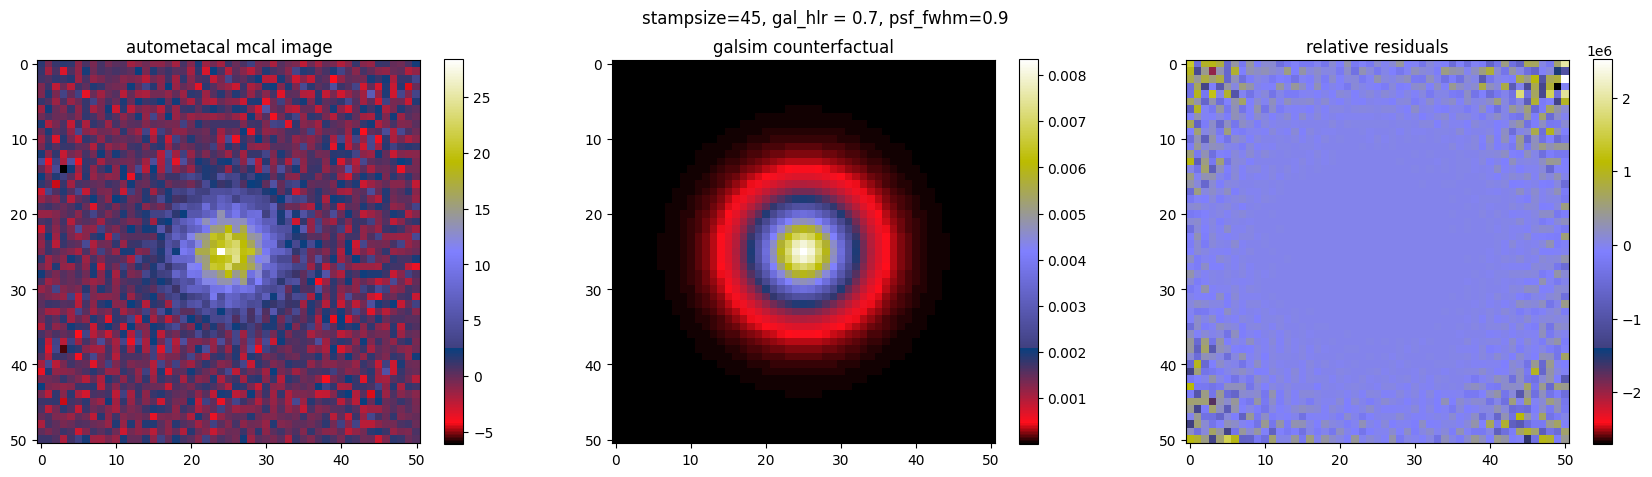

In [13]:
obj0 = galsim.Exponential(half_light_radius=gal_hlr)
counterfact = galsim.Convolve([reconv_psf,obj0])
counterfact = tf.expand_dims( tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array),axis=0)

figure(figsize=(21,5))
suptitle('stampsize=45, gal_hlr = 0.7, psf_fwhm=0.9')
subplot(131)
title('autometacal mcal image')
imshow(amc.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images[tf.newaxis,0],reconv_psf_image,[[0.0,0.0]])[0],cmap='gist_stern');colorbar()
subplot(132)
title('galsim counterfactual')
imshow(counterfact[0],cmap='gist_stern');colorbar()

subplot(133)
title('relative residuals')
imshow((amc.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images[tf.newaxis,0],reconv_psf_image,[[0.0,0.0]])[0]-counterfact[0])/counterfact[0],cmap='gist_stern');colorbar()
savefig('autometacal_vs_galsim_65_bigger_padding.png')

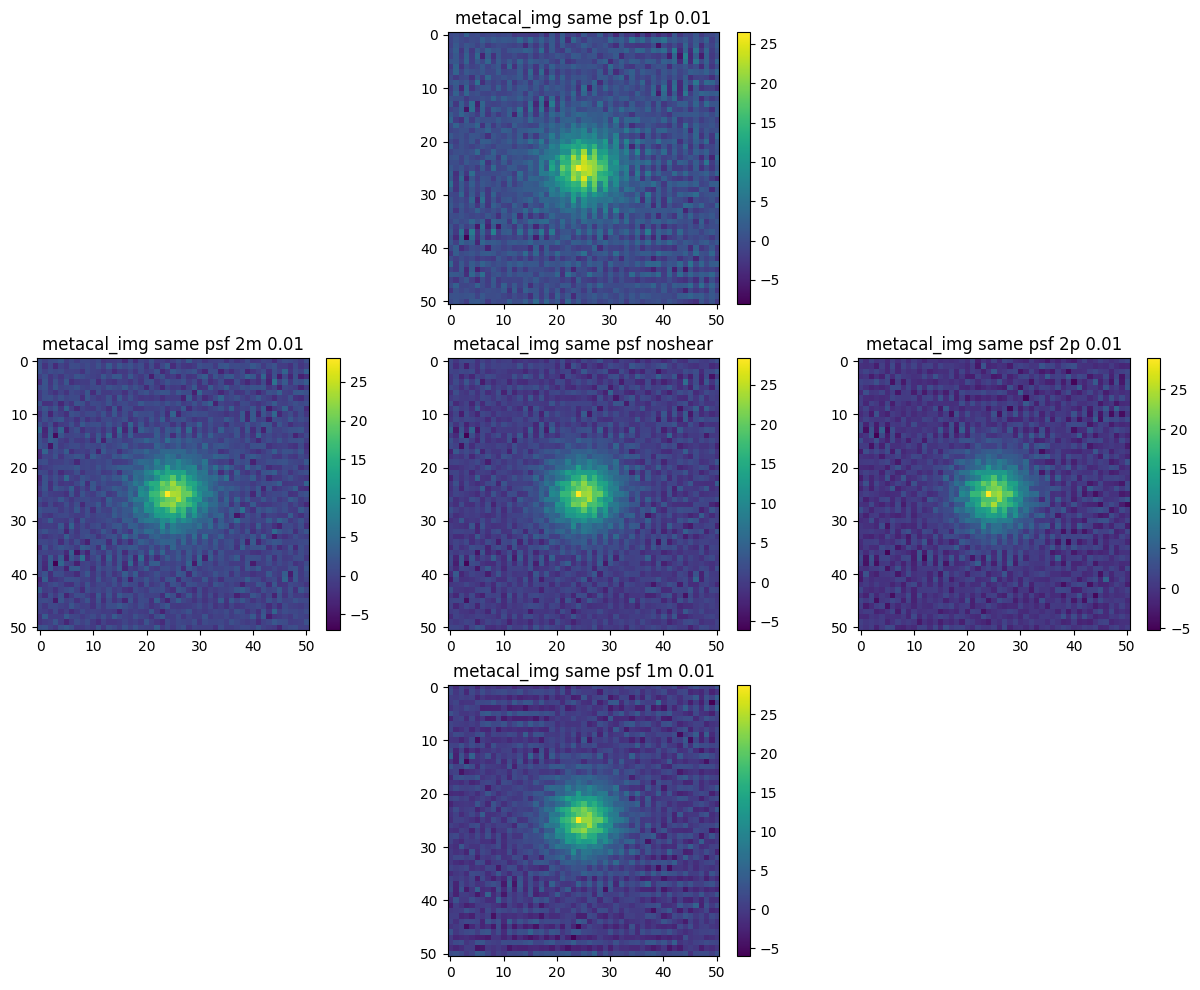

In [14]:
style.use('default')
figure(figsize=(15,12))

step = 0.01

subplot(335)
imshow(amc.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,0.0]])[0]); colorbar()
title('metacal_img same psf noshear')

subplot(332)
imshow(amc.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[step,0.0]])[0]); colorbar()
title(f'metacal_img same psf 1p {step}')

subplot(338)
imshow(amc.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[-step,0.0]])[0]); colorbar()
title(f'metacal_img same psf 1m {step}')

subplot(336)
imshow(amc.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,step]])[0]); colorbar()
title(f'metacal_img same psf 2p {step}')

subplot(334)
imshow(amc.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,-step]])[0]); colorbar()
title(f'metacal_img same psf 2m {step}')
savefig('problems1.png',bbox_inches='tight')

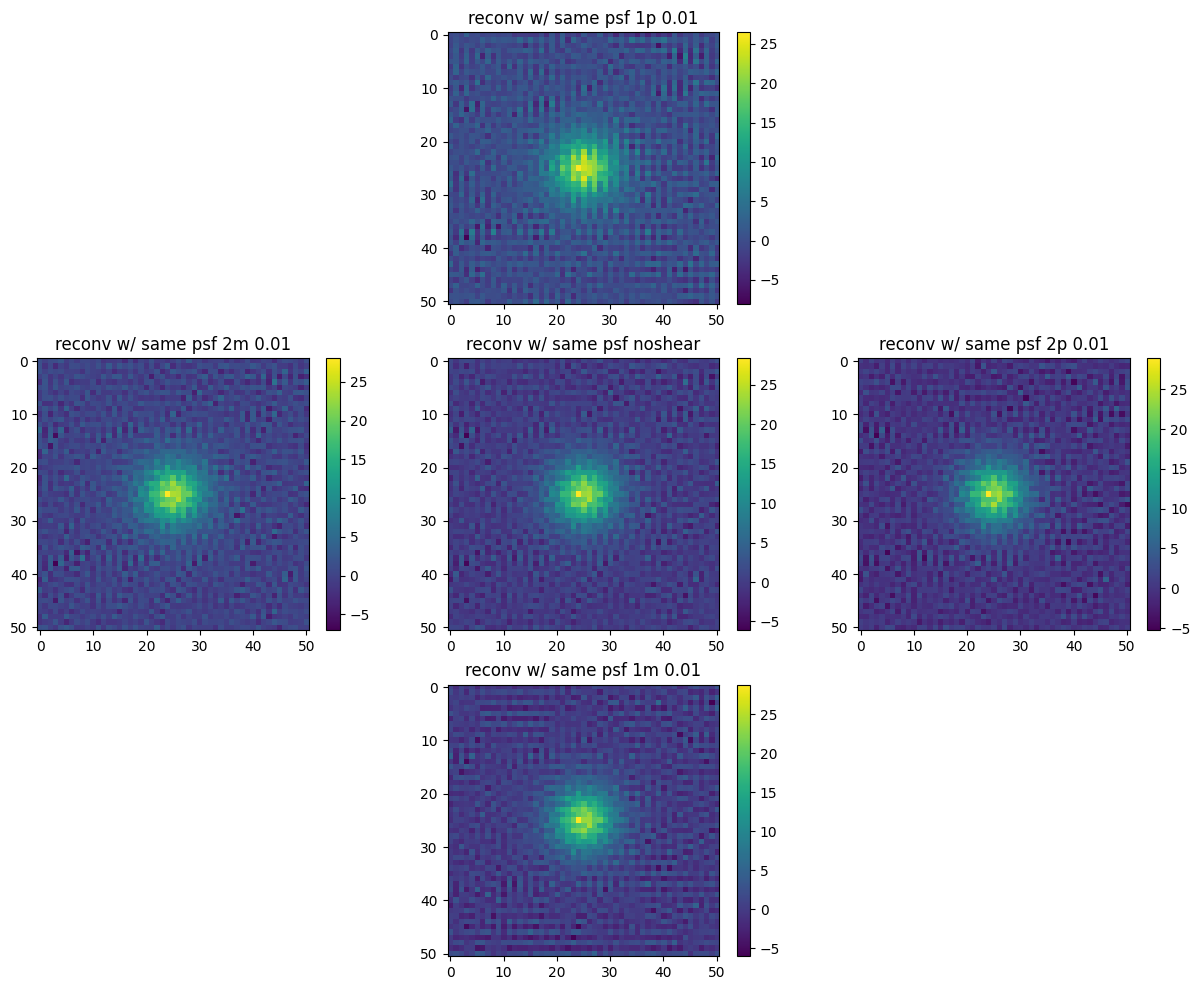

In [15]:
style.use('default')
figure(figsize=(15,12))

step = 0.01

subplot(335)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=0.0,g2=0.0)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(amc.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[0.0,0.0]])[0]-counterfact[0])
title('reconv w/ same psf noshear');colorbar()

subplot(332)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=step,g2=0.0)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(amc.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[step,0.0]])[0]-counterfact[0])
title(f'reconv w/ same psf 1p {step}');colorbar()

subplot(338)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=-step,g2=0.0)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(amc.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[-step,0.0]])[0]-counterfact[0])
title(f'reconv w/ same psf 1m {step}');colorbar()

subplot(336)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=0.0,g2=step)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(amc.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[0.0,step]])[0]-counterfact[0])
title(f'reconv w/ same psf 2p {step}');colorbar()

subplot(334)
counterfact = galsim.Convolve([reconv_psf,obj0.shear(g1=0.0,g2=-step)])
counterfact = tf.convert_to_tensor(counterfact.drawImage(nx=stamp_size, 
                                                         ny=stamp_size, 
                                                         scale=scale).array)[tf.newaxis]
imshow(amc.generate_mcal_image(gal_images[tf.newaxis,0],
                                       psf_images,
                                       reconv_psf_image,[[0.0,-step]])[0]-counterfact[0])
title(f'reconv w/ same psf 2m {step}');colorbar()
savefig('problems2.png',bbox_inches='tight')

## Simple Ellipticity Measurements

In [16]:
get_ellipticities  = lambda x: amc.get_moment_ellipticities(x,scale=0.2,fwhm=1.2)

In [17]:
g1, g2 = get_ellipticities(amc.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,0.0]]))[0]
print(f'0shear  g1={g1: .4f},  g2={g2: .4f}')
print('--------------------------------')
g1, g2 = get_ellipticities(amc.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.05,0.0]]))[0]
print(f'1p .05  g1={g1: .4f},  g2={g2: .4f}')
g1, g2 = get_ellipticities(amc.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[-.05,0.0]]))[0]
print(f'1m .05  g1={g1: .4f},  g2={g2: .4f}')
g1, g2 = get_ellipticities(amc.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,0.05]]))[0]
print(f'2p .05  g1={g1: .4f},  g2={g2: .4f}')
g1, g2 = get_ellipticities(amc.generate_mcal_image(gal_images[tf.newaxis,0],psf_images,reconv_psf_image,[[0.0,-.05]]))[0]
print(f'2m .05  g1={g1: .4f},  g2={g2: .4f}')

0shear  g1= 0.0038,  g2=-0.0015
--------------------------------
1p .05  g1= 0.0164,  g2=-0.0011
1m .05  g1=-0.0088,  g2=-0.0019
2p .05  g1= 0.0042,  g2= 0.0118
2m .05  g1= 0.0035,  g2=-0.0148


## Autodiff

In [18]:
e, R =amc.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
for e, R in zip(e,R):
  calibre=tf.linalg.inv(R) @ tf.reshape(e,[2,1])
  print(f'g1 = {calibre[0,0]: .5f}, g2 = {calibre[1,0]: .5f}')

g1 =  0.01546, g2 = -0.00613


In [19]:
e, R = amc.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
calibre0 = tf.linalg.inv(R[0]) @ tf.reshape(e[0],[2,1])

## Single image comparison between Autodiff and Finite diff

In [21]:
steps = np.logspace(-5,0,100).astype('float32')
ef_list = []
R11f_list = [] 
R12f_list = []
R21f_list = []
R22f_list = []
for step in steps:

  e_f, R_f=amc.get_metacal_response_finitediff(gal_images[tf.newaxis,0],
                                               psf_images[tf.newaxis,0],
                                               reconv_psf_image,
                                               tf.zeros([1,2],dtype=tf.float32),
                                               step,
                                               get_ellipticities)
  R11f_list.append(R_f[0,0,0])
  R12f_list.append(R_f[0,0,1])
  R21f_list.append(R_f[0,1,0])
  R22f_list.append(R_f[0,1,1])
  try:
    calibre_f=tf.linalg.inv(R_f) @ tf.reshape(e_f['noshear'],[2,1])
    ef_list.append(np.sqrt(sum(calibre_f**2)))
    
  except:
    ef_list.append(np.nan)
    print('Ops!')

Ops!


In [22]:
e = np.sqrt(sum(calibre0**2))

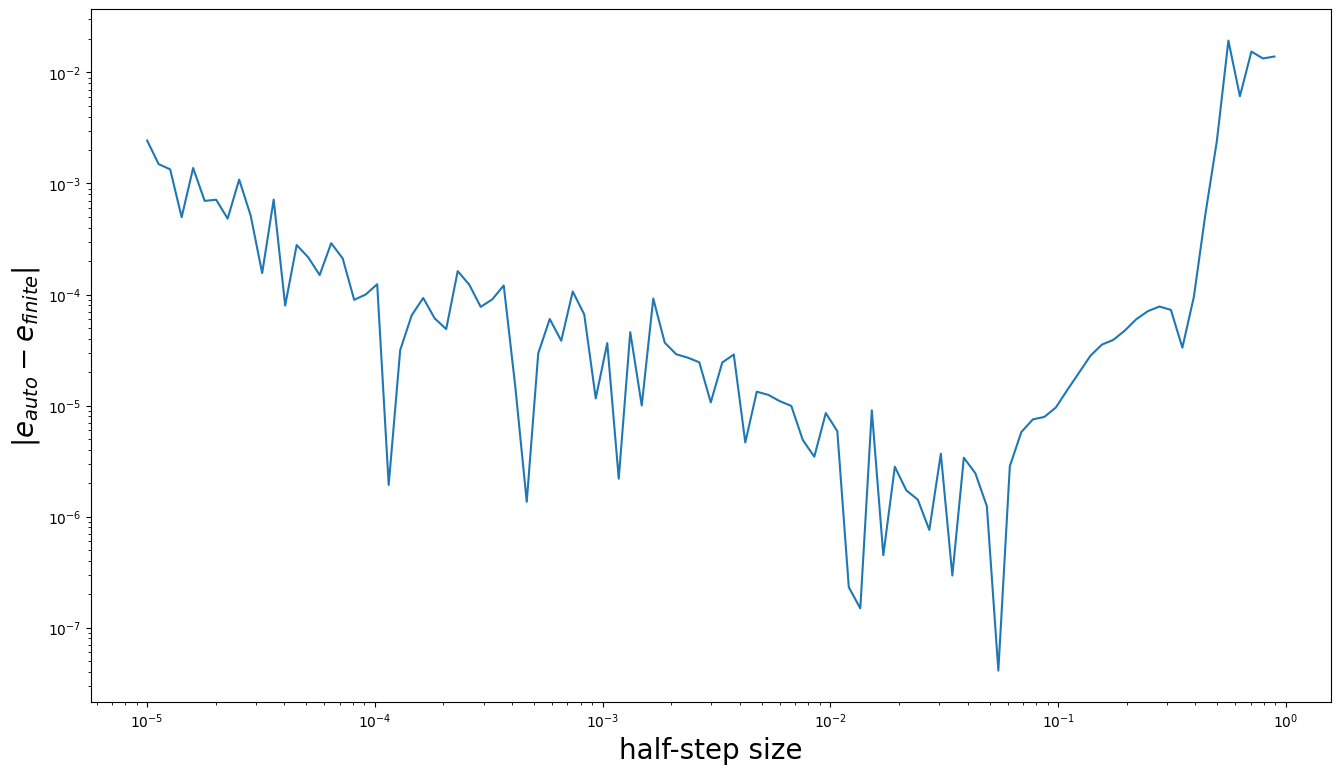

In [23]:
figure(figsize=(16,9))
plot(steps,abs(e-np.array(ef_list)) )
xscale('log')
yscale('log')
ylabel('$|e_{auto} - e_{finite}|$',fontsize=20)
xlabel('half-step size',fontsize=20)
savefig(f'autofinite{time.time()}.jpeg',bbox_inches='tight')

In [24]:
R11 = R[0,0,0]
R12 = R[0,0,1]
R21 = R[0,1,0]
R22 = R[0,1,1]

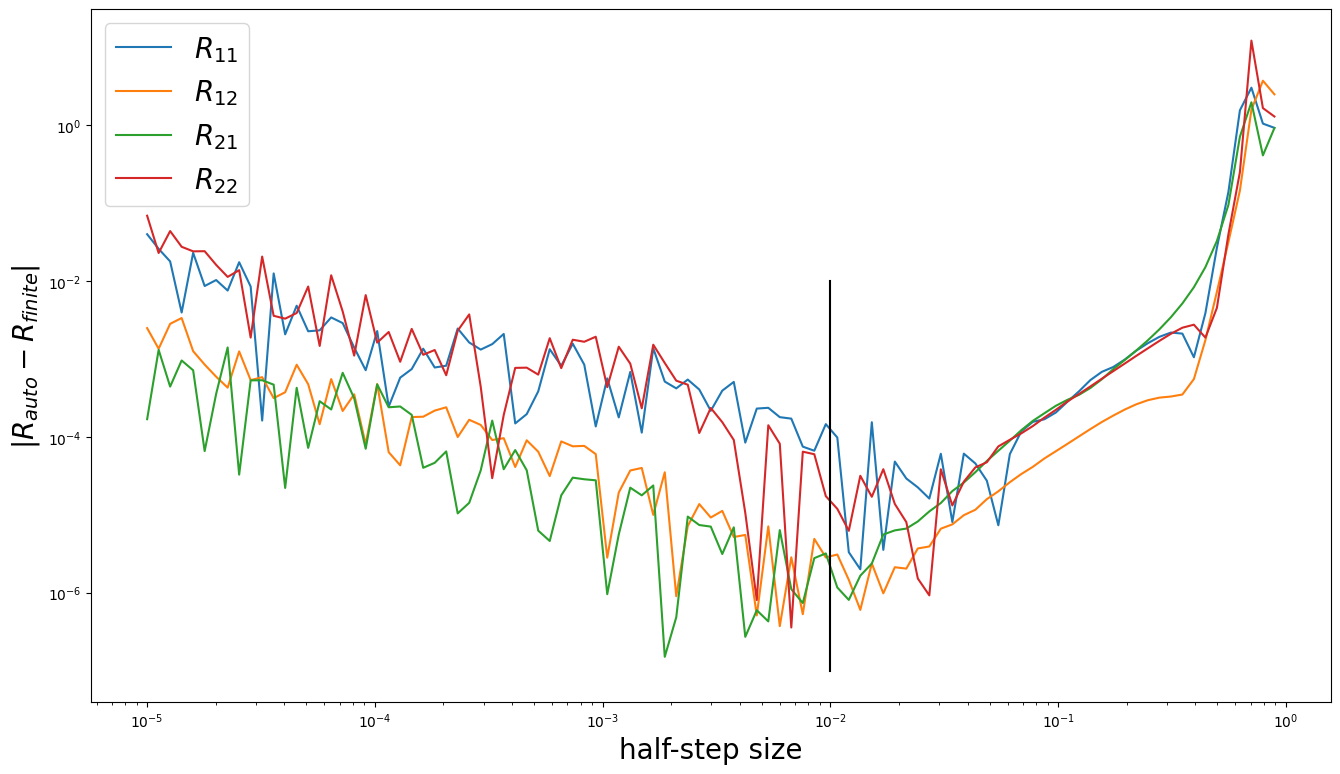

In [ ]:
figure(figsize=(16,9))
plot(steps,abs(R11-np.array(R11f_list)),label="$R_{11}$" )
plot(steps,abs(R12-np.array(R12f_list)),label="$R_{12}$" )
plot(steps,abs(R21-np.array(R21f_list)),label="$R_{21}$" )
plot(steps,abs(R22-np.array(R22f_list)),label="$R_{22}$" )
plot([1e-2,1e-2],[1e-7,1e-2],'k-')
xscale('log')
yscale('log')
#ylim([1.5e-4,3e-4])
ylabel('$|R_{auto}-R_{finite}|$',fontsize=20)
xlabel('half-step size',fontsize=20)
legend(fontsize=20)
savefig(f'autofinite_response_log.jpeg',bbox_inches='tight')

## Galaxy Batches

In [26]:
from scipy.stats import truncnorm

In [27]:
g_list = []
i=0
gmax=.7
gscale = .2
gloc=0
Ngal=1000
while i<Ngal :
  a, b = (-gmax - gloc) / gscale, (gmax - gloc) / gscale
  g1=g2=1
  #select ellipticities, ensure g<=1
  while g1**2+g2**2>1:
    g1 = truncnorm.rvs(a, b, loc=gloc, scale=gscale)
    g2 = truncnorm.rvs(a, b, loc=gloc, scale=gscale)
    i+=1
  g_list.append([g1,g2])
garray = np.array(g_list)

In [28]:
gal_images, psf_images = make_data(N=Ngal,
                                  snr = snr,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm,
                                  gal_hlr = gal_hlr,
                                  gal_g1=garray.T[0],gal_g2=garray.T[1])

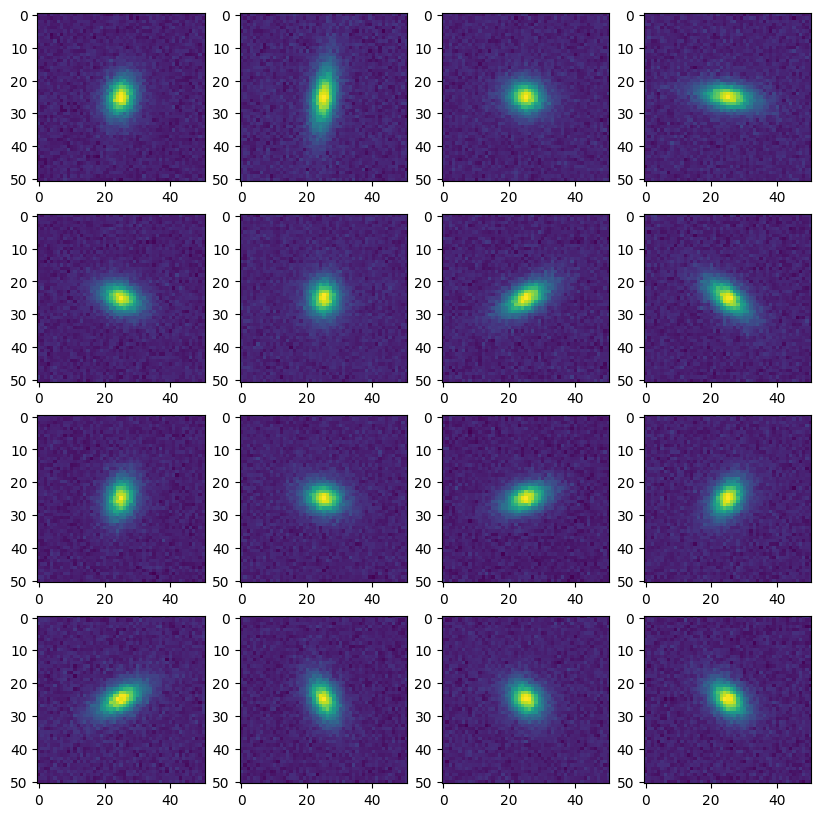

In [29]:
style.use('default')
figure(figsize=(10,10))
for i in range(16):
  subplot(4,4,i+1)
  imshow(gal_images[i])

In [30]:
e_auto, R_auto = amc.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
calibre_f=mean(tf.linalg.inv(R_auto[:]),axis=0) @ tf.reshape(e_auto,[-1,2,1])

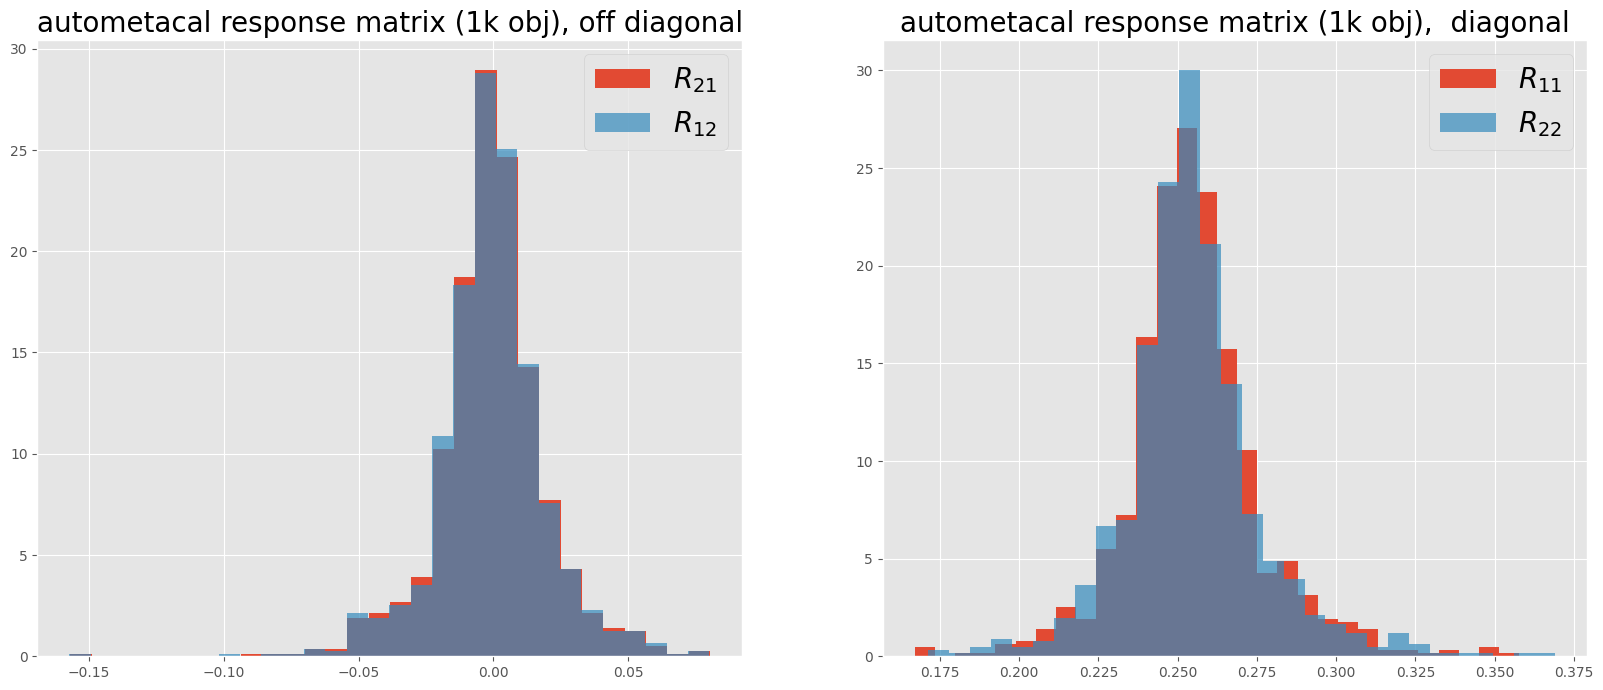

In [31]:
style.use('ggplot')
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=30,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=30,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=30,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=30,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)
savefig('response_distribution.pdf',bbox_inches='tight')

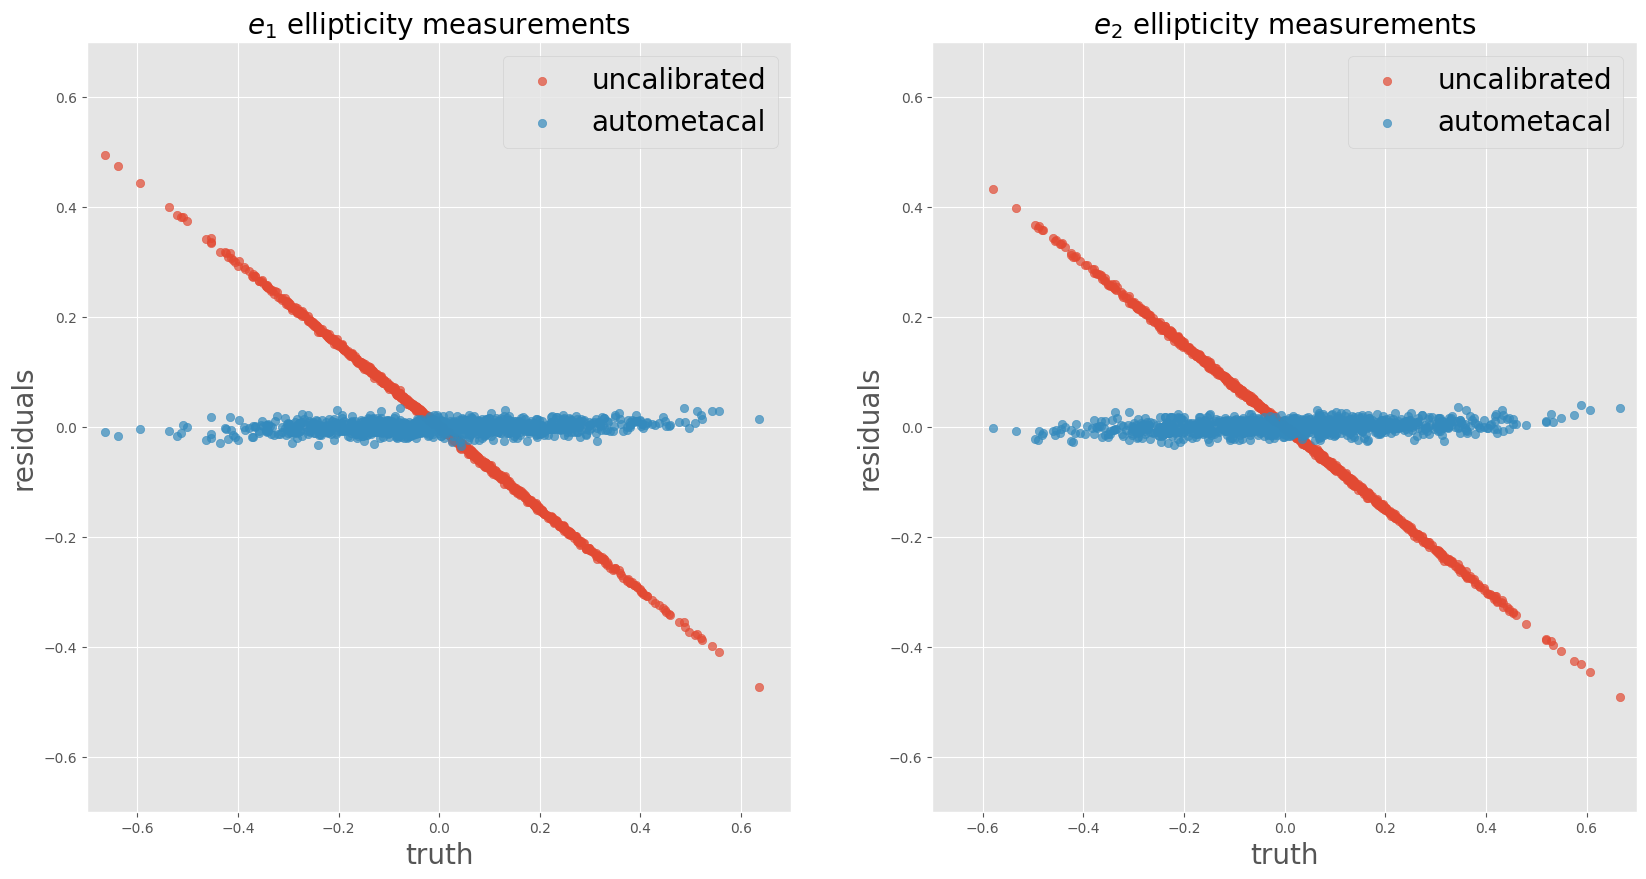

In [32]:
figure(figsize=(20,10))
subplot(121)
scatter(garray[:,0],e_auto[:,0]-garray[:,0],alpha=.7,label="uncalibrated")
scatter(garray[:,0],calibre_f[:,0,0]-garray[:,0],alpha=.7,label="autometacal")
title("$e_1$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-0.7,0.7)
ylim(-0.7,0.7)
subplot(122)
scatter(garray[:,1],e_auto[:,1]-garray[:,1],alpha=.7,label="uncalibrated")
scatter(garray[:,1],calibre_f[:,1,0]-garray[:,1],alpha=.7,label="autometacal")
title("$e_2$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-0.7,0.7)
ylim(-0.7,0.7)
savefig("linearity.pdf",bbox_inches="tight")

* *This is not an École Polytechnique ad.* :-)

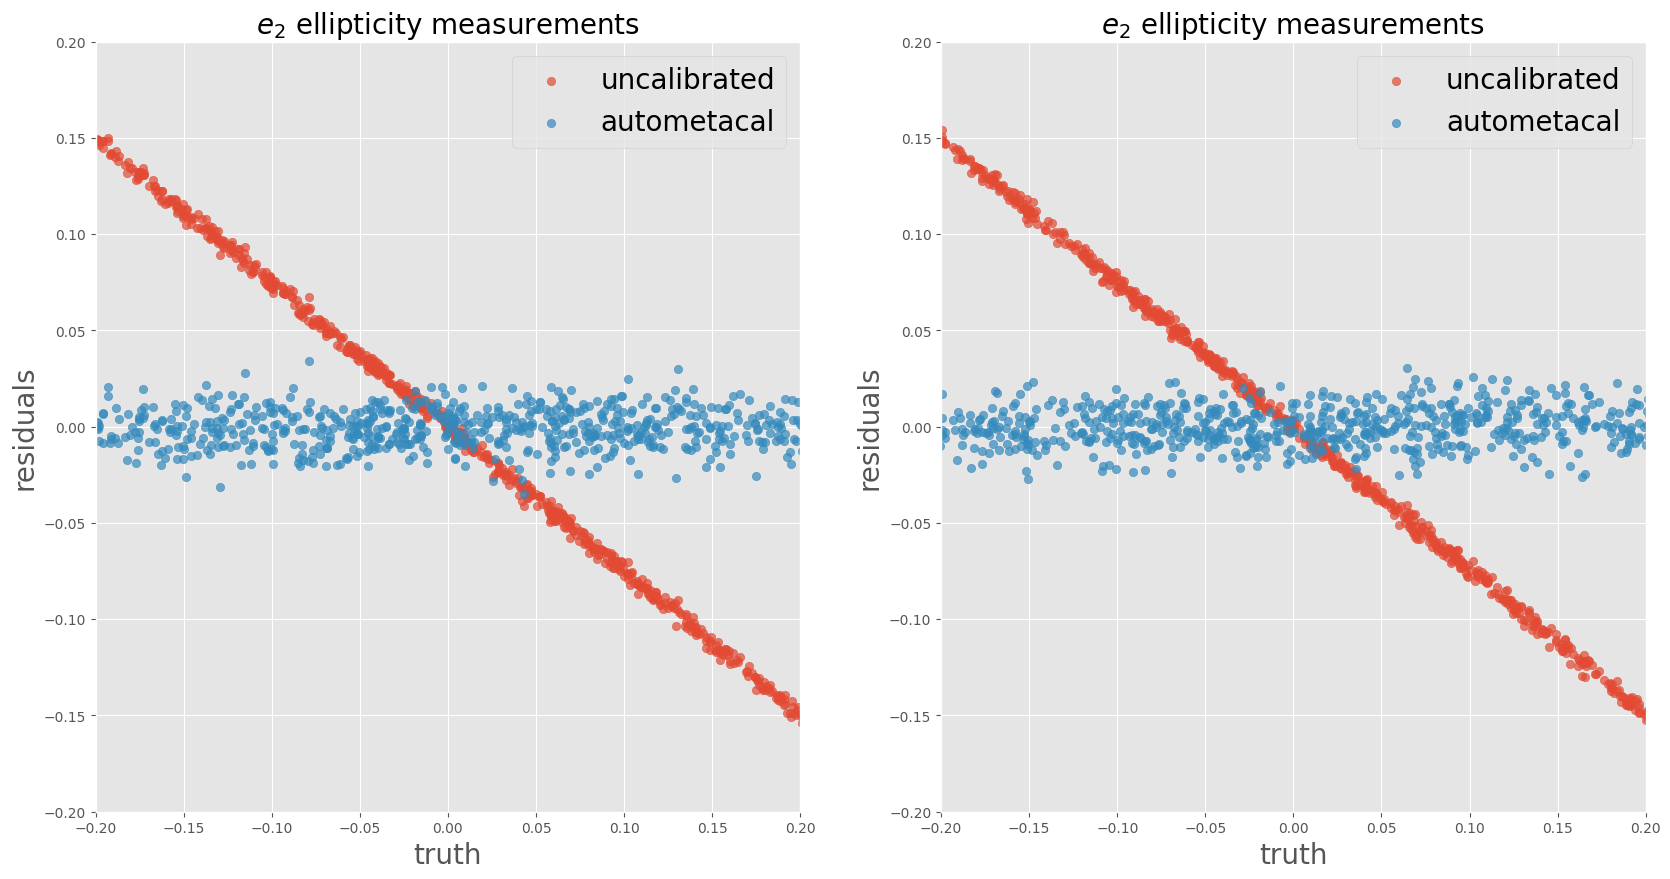

In [33]:
style.use('ggplot')
figure(figsize=(20,10))
box_size=.2
subplot(121)
scatter(garray[:,0],e_auto[:,0]-garray[:,0],alpha=.7,label="uncalibrated")
scatter(garray[:,0],calibre_f[:,0,0]-garray[:,0],alpha=.7,label="autometacal")
title("$e_1$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-box_size,box_size)
ylim(-box_size,box_size)

subplot(122)
scatter(garray[:,1],e_auto[:,1]-garray[:,1],alpha=.7,label="uncalibrated")
scatter(garray[:,1],calibre_f[:,1,0]-garray[:,1],alpha=.7,label="autometacal")
title("$e_2$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-box_size,box_size)
ylim(-box_size,box_size)
savefig("linearity_zoomed.pdf",bbox_inches="tight")

## Averaging the response comparison over many galaxies

In [34]:
e_auto, R_auto = amc.get_metacal_response(
  gal_images,
  psf_images,
  reconv_psf_image,
  get_ellipticities)

calibre_f=tf.linalg.inv(R_auto[:]) @ tf.reshape(e_auto,[-1,2,1])

In [35]:
e_finite_list = []
R_finite_list = []
for step in tqdm.tqdm(steps):
    e_finite, R_finite = get_metacal_response_finitediff(
      gal_images,
      psf_images,
      reconv_psf_image,
      tf.zeros([Ngal,2],dtype=tf.float32),
      step=step,
      method=get_ellipticities
    )
    e_finite_list.append(e_finite)
    R_finite_list.append(R_finite)
    
R_finite=np.array(R_finite_list)    


100%|██████████| 100/100 [12:09<00:00,  7.29s/it]


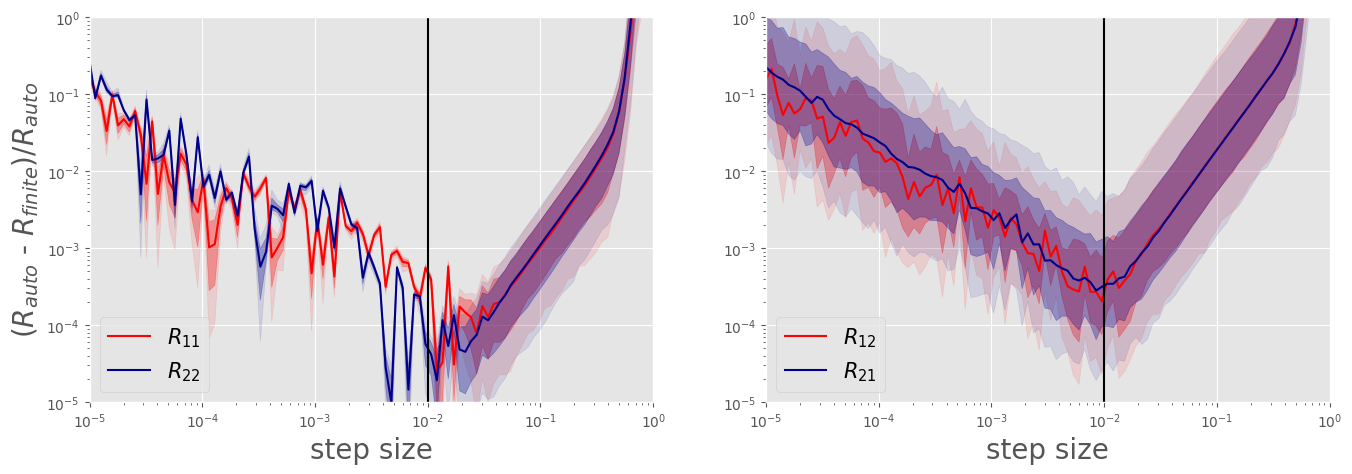

In [36]:
style.use('ggplot')
figure(figsize=(16,5))
subplot(121)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0])/abs(R_auto[:,0,0]),[95],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0])/abs(R_auto[:,0,0]),[5],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.1)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0])/abs(R_auto[:,0,0]),[84],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0])/abs(R_auto[:,0,0]),[16],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.3)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1])/abs(R_auto[:,1,1]),[95],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1])/abs(R_auto[:,1,1]),[5],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.1)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1])/abs(R_auto[:,1,1]),[84],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1])/abs(R_auto[:,1,1]),[16],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.3)


plot(steps,np.median(abs(R_auto[:,0,0]-R_finite[:,:,0,0])/abs(R_auto[:,0,0]),axis=1),label="$R_{11}$",color='red')
plot(steps,np.median(abs(R_auto[:,1,1]-R_finite[:,:,1,1])/abs(R_auto[:,1,1]),axis=1),label="$R_{22}$",color='darkblue')

plot([1e-2,1e-2],[1e-5,1e-0],'k-')
ylim([1e-5,1e0])
xlim([1e-5,1e0])
xlabel('step size',fontsize=20)
ylabel('$(R_{auto}$ - $R_{finite})/R_{auto}$',fontsize=20)
legend(loc=3,fontsize=15)
xscale('log')
yscale('log')

subplot(122)

####CL95
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0])/abs(R_auto[:,1,0]),[95],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0])/abs(R_auto[:,1,0]),[5],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.1)
####CL68
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0])/abs(R_auto[:,1,0]),[84],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0])/abs(R_auto[:,1,0]),[16],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.3)


Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1])/abs(R_auto[:,0,1]),[95],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1])/abs(R_auto[:,0,1]),[5],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.1)

Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1])/abs(R_auto[:,0,1]),[84],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1])/abs(R_auto[:,0,1]),[16],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.3)

plot(steps,(np.median(abs(R_auto[:,1,0]-R_finite[:,:,1,0])/abs(R_auto[:,1,0]),axis=1)),label="$R_{12}$",color='red')
plot(steps,(np.median(abs(R_auto[:,0,1]-R_finite[:,:,0,1])/abs(R_auto[:,0,1]),axis=1)),label="$R_{21}$",color='darkblue')
plot([1e-2,1e-2],[1e-5,1e-0],'k-')
ylim([1e-5,1e0])
xlim([1e-5,1e0])
xlabel('step size',fontsize=20)

legend(loc=3,fontsize=15)
xscale('log')
yscale('log')
savefig('median_response.pdf',bbox_inches='tight')

## Various SNR Levels

In [37]:
noises1 = np.array([60,80,100,120,140,160,180,200])
noises = np.array([60,80,100,120,160,180,200])

In [38]:
R11list = []
R22list = []
R21list = []
R12list = []
for noise in tqdm.tqdm(noises):
  gal_images, psf_images = make_data(N=Ngal,
                                    snr = noise,
                                    scale = scale,
                                    stamp_size = stamp_size,
                                    psf_fwhm = psf_fwhm,
                                    gal_hlr = gal_hlr,
                                    gal_g1=garray.T[0],gal_g2=garray.T[1])

  e_finite_list = []
  R_finite_list = []
  for step in steps:
      e_finite, R_finite = amc.get_metacal_response_finitediff(gal_images,
                                                           psf_images,
                                                           reconv_psf_image,
                                                           shear=tf.zeros([Ngal,2]),
                                                           step=step,
                                                           method=get_ellipticities)
      e_finite_list.append(e_finite)
      R_finite_list.append(R_finite)

  R_finite=np.array(R_finite_list)    
  e_auto, R_auto = amc.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
  calibre_f=tf.linalg.inv(R_auto[:]) @ tf.reshape(e_auto,[-1,2,1])
  R11_comparison = np.median(abs(R_auto[:,0,0]-R_finite[:,:,0,0])/abs(R_auto[:,0,0]),axis=1)
  R22_comparison = np.median(abs(R_auto[:,1,1]-R_finite[:,:,1,1])/abs(R_auto[:,1,1]),axis=1)
  R21_comparison = np.median(abs(R_auto[:,1,0]-R_finite[:,:,1,0])/abs(R_auto[:,1,0]),axis=1)
  R12_comparison = np.median(abs(R_auto[:,0,1]-R_finite[:,:,0,1])/abs(R_auto[:,0,1]),axis=1)
  
  R11list.append(R11_comparison)
  R22list.append(R22_comparison)
  R21list.append(R21_comparison)
  R12list.append(R12_comparison)

  0%|          | 0/7 [00:00<?, ?it/s]

 14%|█▍        | 1/7 [12:26<1:14:40, 746.77s/it]

 29%|██▊       | 2/7 [25:07<1:02:54, 754.90s/it]

 43%|████▎     | 3/7 [37:47<50:28, 757.23s/it]  

 57%|█████▋    | 4/7 [50:00<37:22, 747.65s/it]

 71%|███████▏  | 5/7 [1:02:25<24:53, 746.73s/it]

 86%|████████▌ | 6/7 [1:15:06<12:31, 751.61s/it]

100%|██████████| 7/7 [1:27:44<00:00, 752.05s/it]


In [39]:
R11array = np.array(R11list)
R22array = np.array(R22list)
R21array = np.array(R21list)
R12array = np.array(R12list)

In [40]:
save("R11array.npy",R11array)
save("R22array.npy",R22array)
save("R21array.npy",R21array)
save("R12array.npy",R12array)

In [41]:
R11array=load("R11array.npy",)
R22array=load("R22array.npy",)
R21array=load("R21array.npy",)
R12array=load("R12array.npy",)
noises1 = np.array([60,80,100,120,140,160,180,200])
noises = np.array([60,80,100,120,160,180,200])

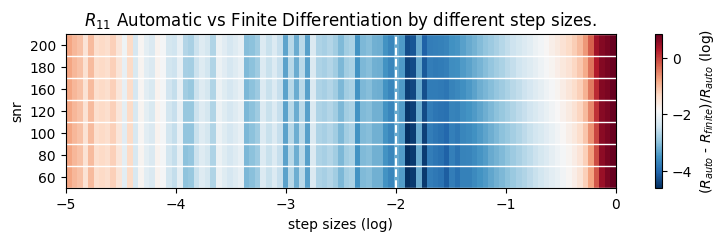

In [42]:
logarray = log10(R11array)[:,:-1]
style.use('default')
fig, ax = subplots(figsize=(10,2))
imshow(logarray, extent=[-5,0,60,200],aspect='0.01',cmap='RdBu_r')
colorbar(label='$(R_{auto}$ - $R_{finite})/R_{auto}$ (log)')
plot([-2,-2],[noises[0],noises[-1]],'w--')
for noise in noises1:
  plot([-5,0],[noise,noise],linewidth=1,color='white')
ylabel('snr')
yticks([70,90,110,130,150,170,190])
ax.set_yticklabels(noises)
xlabel('step sizes (log)')
title('$R_{11}$ Automatic vs Finite Differentiation by different step sizes.')
savefig('autodiff_vs_finitediff_R11.pdf',bbox_inches='tight')

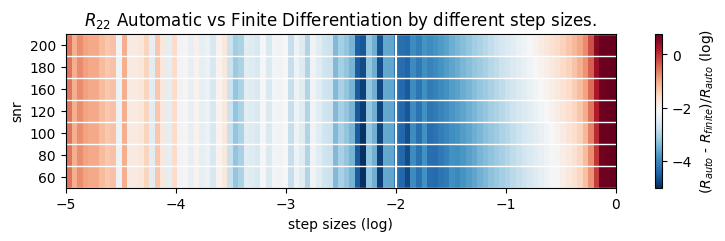

In [43]:
logarray = log10(R22array)[:,:-1]
style.use('default')
fig, ax = subplots(figsize=(10,2))
imshow(logarray,extent=[-5,0,60,200],aspect='0.01',cmap='RdBu_r')
colorbar(label='$(R_{auto}$ - $R_{finite})/R_{auto}$ (log)')
plot([-2,-2],[noises[0],noises[-1]],color='w')
for noise in noises1:
  plot([-5,0],[noise,noise],linewidth=1,color='white')
ylabel('snr')
yticks([70,90,110,130,150,170,190])
ax.set_yticklabels(noises)
xlabel('step sizes (log)')
title('$R_{22}$ Automatic vs Finite Differentiation by different step sizes.')
savefig('autodiff_vs_finitediff_R22.pdf',bbox_inches='tight')

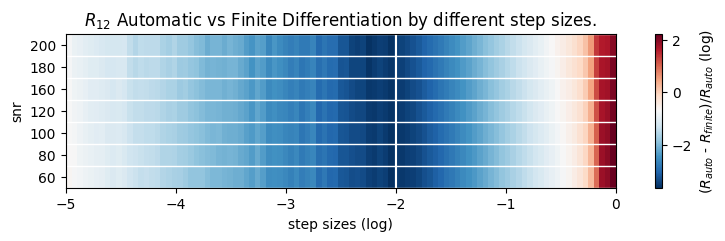

In [44]:
logarray = log10(R12array)[:,:-1]
style.use('default')
fig, ax = subplots(figsize=(10,2))
imshow(logarray,extent=[-5,0,60,200],aspect='0.01',cmap='RdBu_r')
colorbar(label='$(R_{auto}$ - $R_{finite})/R_{auto}$ (log)')
plot([-2,-2],[noises[0],noises[-1]],color='w')
for noise in noises1:
  plot([-5,0],[noise,noise],linewidth=1,color='white')
ylabel('snr')
yticks([70,90,110,130,150,170,190])
ax.set_yticklabels(noises)
xlabel('step sizes (log)')
title('$R_{12}$ Automatic vs Finite Differentiation by different step sizes.')

savefig('autodiff_vs_finitediff_R12.pdf',bbox_inches='tight')

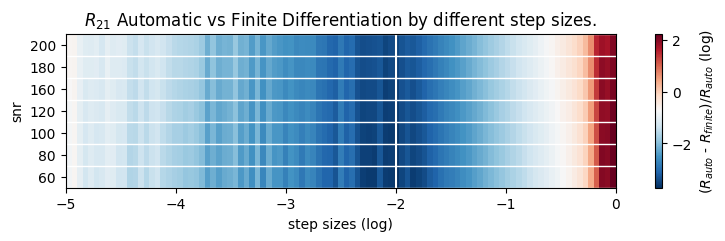

In [45]:
logarray = log10(R21array)[:,:-1]
style.use('default')
fig, ax = subplots(figsize=(10,2))
imshow(logarray,extent=[-5,0,60,200],aspect='0.01',cmap='RdBu_r')
colorbar(label='$(R_{auto}$ - $R_{finite})/R_{auto}$ (log)')
plot([-2,-2],[noises[0],noises[-1]],color='w')
for noise in noises1:
  plot([-5,0],[noise,noise],linewidth=1,color='white')
ylabel('snr')
yticks([70,90,110,130,150,170,190])
ax.set_yticklabels(noises)
xlabel('step sizes (log)')
title('$R_{21}$ Automatic vs Finite Differentiation by different step sizes.')

savefig('autodiff_vs_finitediff_R21.pdf',bbox_inches='tight')

# Ensenble response

In [51]:
gal_images, psf_images = make_data(N=Ngal,
                                  snr = 2000,
                                  scale = scale,
                                  stamp_size = stamp_size,
                                  psf_fwhm = psf_fwhm,
                                  gal_hlr = gal_hlr,
                                  gal_g1=garray.T[0],gal_g2=garray.T[1])

In [52]:
e_auto, R_auto = amc.get_metacal_response(gal_images,psf_images,reconv_psf_image,get_ellipticities)
calibre_f=mean(tf.linalg.inv(R_auto[:]),axis=0) @ tf.reshape(e_auto,[-1,2,1])

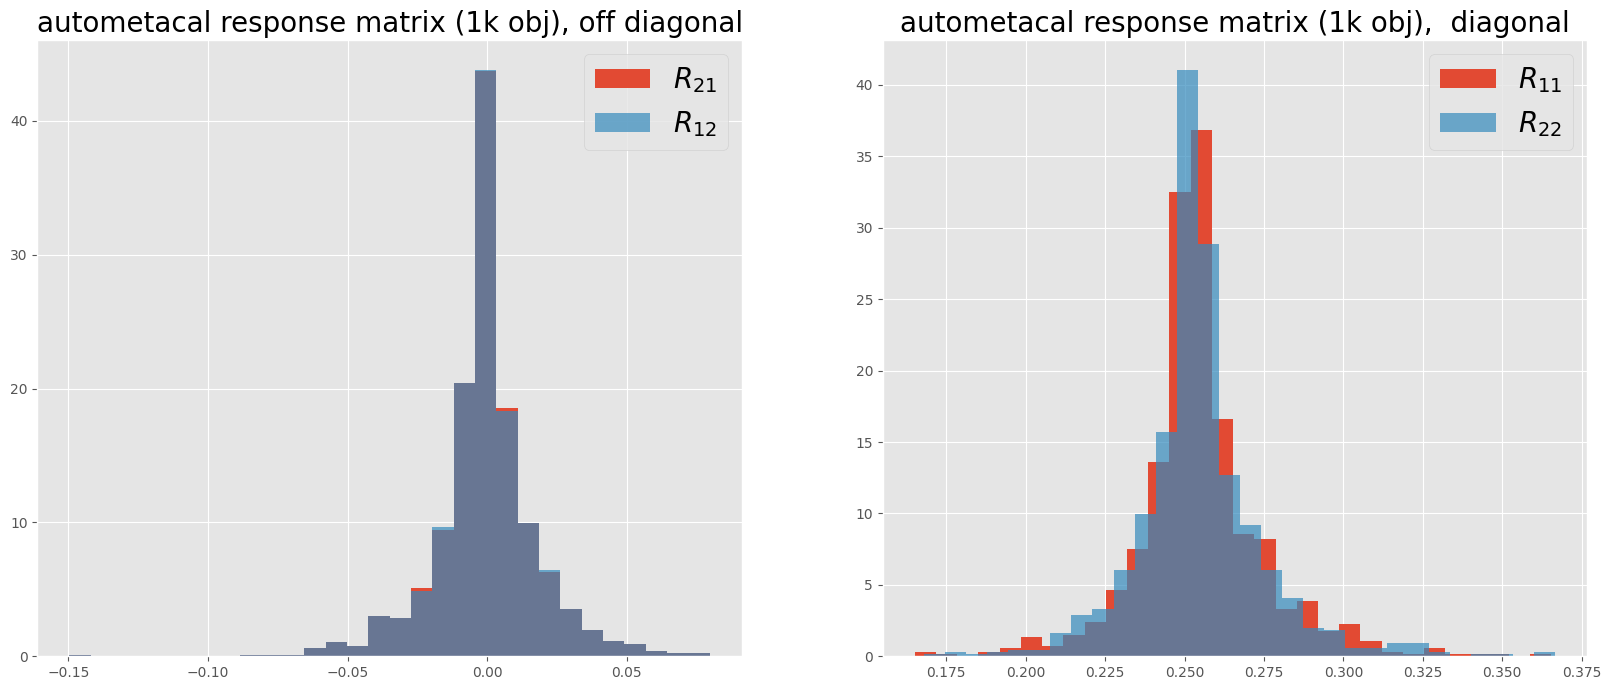

In [53]:
style.use('ggplot')
figure(figsize=(20,8))
subplot(122)
hist(R_auto[:,0,0].numpy()[:],bins=30,density=True,label="$R_{11}$");
hist(R_auto[:,1,1].numpy()[:],bins=30,density=True,label="$R_{22}$",alpha=.7);
title("autometacal response matrix (1k obj),  diagonal",fontsize=20)
legend(fontsize=20)
subplot(121)
hist(R_auto[:,1,0].numpy()[:],bins=30,label="$R_{21}$",density=True);
hist(R_auto[:,0,1].numpy()[:],bins=30,label="$R_{12}$",density=True,alpha=.7);
title("autometacal response matrix (1k obj), off diagonal",fontsize=20)
legend(fontsize=20)
savefig('response_distribution_high_snr.pdf',bbox_inches='tight')

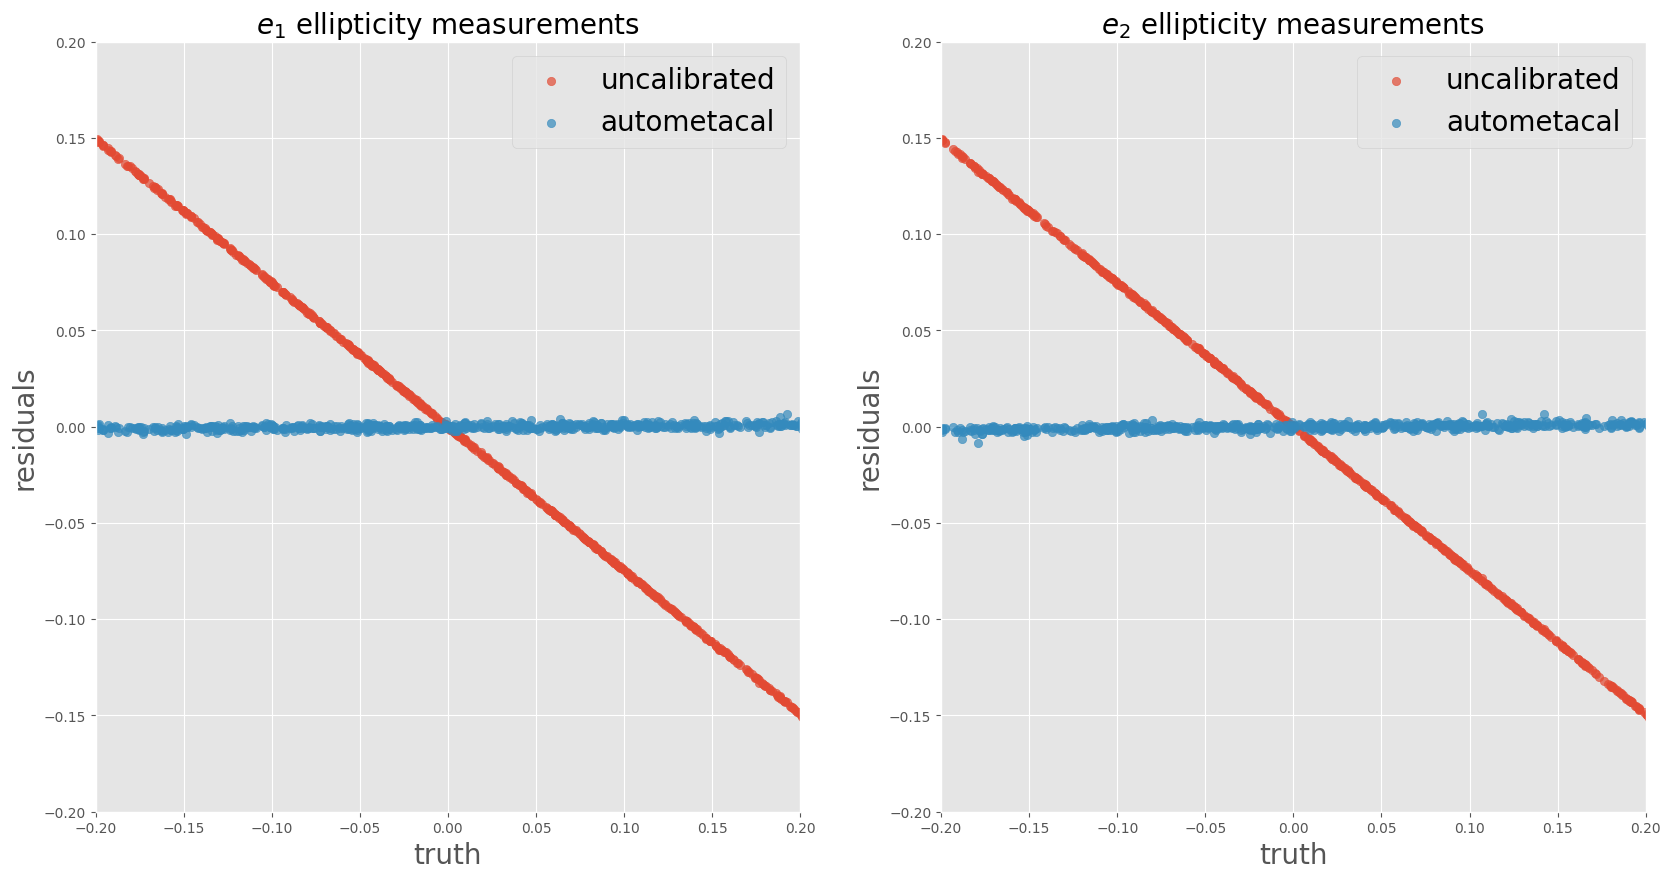

In [54]:
style.use('ggplot')
figure(figsize=(20,10))
box_size=.2
subplot(121)
scatter(garray[:,0],e_auto[:,0]-garray[:,0],alpha=.7,label="uncalibrated")
scatter(garray[:,0],calibre_f[:,0,0]-garray[:,0],alpha=.7,label="autometacal")
title("$e_1$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-box_size,box_size)
ylim(-box_size,box_size)

subplot(122)
scatter(garray[:,1],e_auto[:,1]-garray[:,1],alpha=.7,label="uncalibrated")
scatter(garray[:,1],calibre_f[:,1,0]-garray[:,1],alpha=.7,label="autometacal")
title("$e_2$ ellipticity measurements", fontsize=20)
xlabel("truth",fontsize=20)
ylabel("residuals",fontsize=20)
legend(fontsize=20)
xlim(-box_size,box_size)
ylim(-box_size,box_size)
savefig("linearity_zoomed_high_snr.pdf",bbox_inches="tight")

In [55]:
e_finite_list = []
R_finite_list = []
for step in tqdm.tqdm(steps):
    e_finite, R_finite = get_metacal_response_finitediff(
      gal_images,
      psf_images,
      reconv_psf_image,
      tf.zeros([Ngal,2],dtype=tf.float32),
      step=step,
      method=get_ellipticities
    )
    e_finite_list.append(e_finite)
    R_finite_list.append(R_finite)
    
R_finite=np.array(R_finite_list)    

100%|██████████| 100/100 [11:58<00:00,  7.18s/it]


Median difference between galaxies

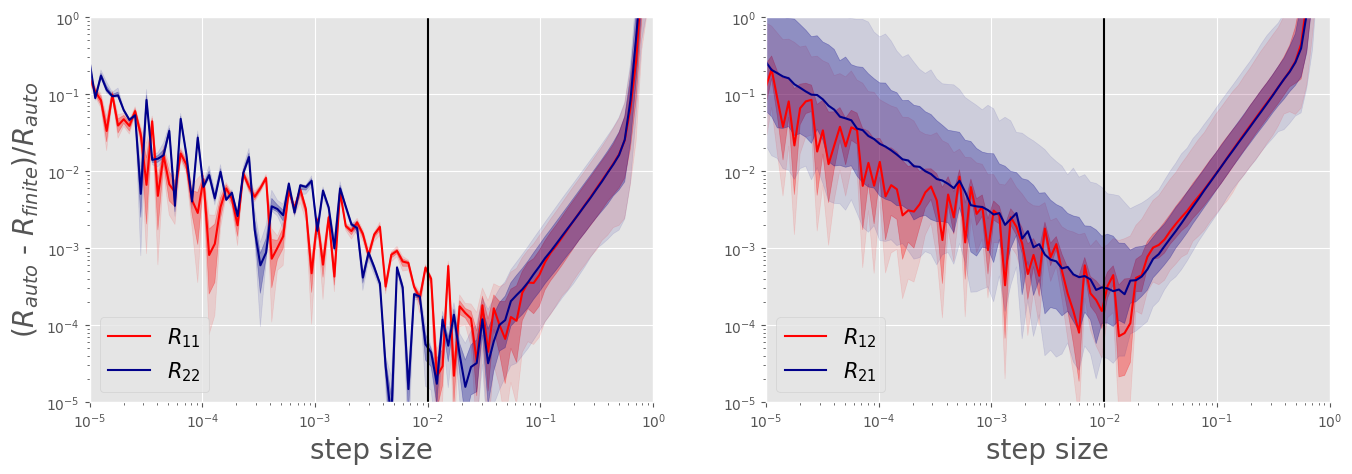

In [56]:
style.use('ggplot')
figure(figsize=(16,5))
subplot(121)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0])/abs(R_auto[:,0,0]),[95],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0])/abs(R_auto[:,0,0]),[5],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.1)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0])/abs(R_auto[:,0,0]),[84],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0])/abs(R_auto[:,0,0]),[16],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.3)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1])/abs(R_auto[:,1,1]),[95],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1])/abs(R_auto[:,1,1]),[5],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.1)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1])/abs(R_auto[:,1,1]),[84],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1])/abs(R_auto[:,1,1]),[16],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.3)


plot(steps,np.median(abs(R_auto[:,0,0]-R_finite[:,:,0,0])/abs(R_auto[:,0,0]),axis=1),label="$R_{11}$",color='red')
plot(steps,np.median(abs(R_auto[:,1,1]-R_finite[:,:,1,1])/abs(R_auto[:,1,1]),axis=1),label="$R_{22}$",color='darkblue')

plot([1e-2,1e-2],[1e-5,1e-0],'k-')
ylim([1e-5,1e0])
xlim([1e-5,1e0])
xlabel('step size',fontsize=20)
ylabel('$(R_{auto}$ - $R_{finite})/R_{auto}$',fontsize=20)
legend(loc=3,fontsize=15)
xscale('log')
yscale('log')

subplot(122)

####CL95
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0])/abs(R_auto[:,1,0]),[95],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0])/abs(R_auto[:,1,0]),[5],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.1)
####CL68
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0])/abs(R_auto[:,1,0]),[84],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0])/abs(R_auto[:,1,0]),[16],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.3)


Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1])/abs(R_auto[:,0,1]),[95],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1])/abs(R_auto[:,0,1]),[5],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.1)

Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1])/abs(R_auto[:,0,1]),[84],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1])/abs(R_auto[:,0,1]),[16],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.3)

plot(steps,(np.median(abs(R_auto[:,1,0]-R_finite[:,:,1,0])/abs(R_auto[:,1,0]),axis=1)),label="$R_{12}$",color='red')
plot(steps,(np.median(abs(R_auto[:,0,1]-R_finite[:,:,0,1])/abs(R_auto[:,0,1]),axis=1)),label="$R_{21}$",color='darkblue')
plot([1e-2,1e-2],[1e-5,1e-0],'k-')
ylim([1e-5,1e0])
xlim([1e-5,1e0])
xlabel('step size',fontsize=20)

legend(loc=3,fontsize=15)
xscale('log')
yscale('log')
savefig('median_response_high_snr.pdf',bbox_inches='tight')

0.7054802

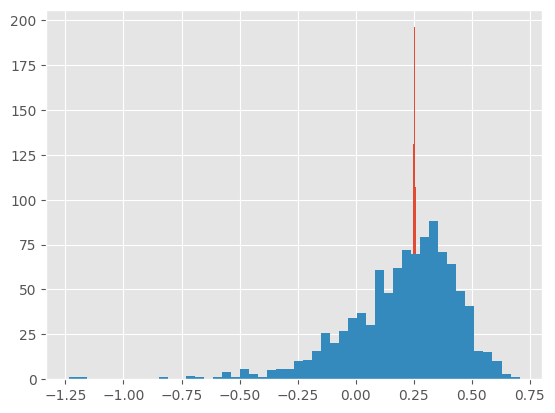

In [113]:
hist(R_auto[:,1,1].numpy(),bins=50);
hist(R_finite[96,:,1,1],bins=50);
steps[96]

In [85]:
R_finite[:-1,:,1,1]

array([[ 3.3639371e-01,  4.4535846e-01,  3.2261014e-01, ...,
         3.2651007e-01,  3.4365803e-01,  3.4302941e-01],
       [ 2.9084036e-01,  3.9513829e-01,  2.7790675e-01, ...,
         2.8278795e-01,  2.9664391e-01,  2.9820877e-01],
       [ 3.1212440e-01,  4.1847846e-01,  2.9876557e-01, ...,
         3.0377513e-01,  3.1898832e-01,  3.1943116e-01],
       ...,
       [ 3.7447003e-01,  2.3113061e-01,  3.9939810e-02, ...,
         2.1392055e-01,  3.4335607e-01,  2.4270098e-01],
       [-2.0650499e-01,  1.6066281e+00,  2.1380861e+00, ...,
         2.2669909e+00,  7.4044180e-01,  1.8151181e+00],
       [ 1.6488322e+00, -2.0200448e+00,  1.7140592e+00, ...,
         1.4151461e+00, -1.2338045e+02,  5.9963685e-01]], dtype=float32)

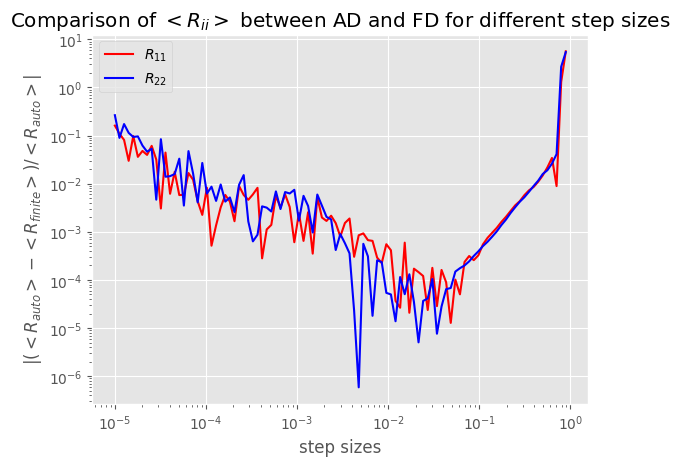

In [122]:
Y = abs(median(R_auto[:,0,0])- median(R_finite[:,:,0,0],axis=1) )/  abs(median(R_auto[:,0,0]))
plot(steps,Y,label="$R_{11}$",color='red')
Y = abs(median(R_auto[:,1,1])- median(R_finite[:,:,1,1],axis=1) )/  abs(median(R_auto[:,1,1]))
plot(steps,Y,label="$R_{22}$",color='blue')
yscale('log')
xscale('log')
legend()
title('Comparison of $<R_{ii}>$ between AD and FD for different step sizes')
ylabel('$|(<R_{auto}>-<R_{finite}>)/<R_{auto}>|$')
xlabel('step sizes')
savefig("difference_of_medians_auto_finite.png",bbox_inches='tight')

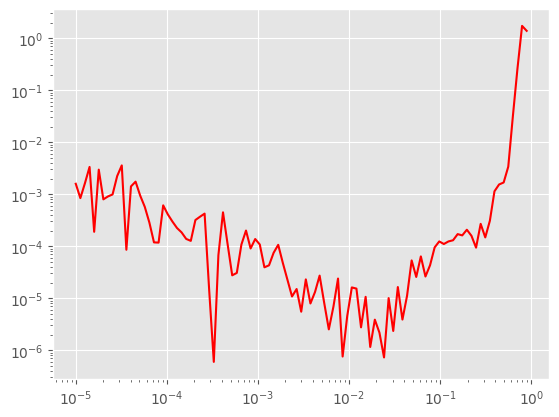

In [73]:
plot(steps,abs(Y1-Y2),label="$R_{11}$",color='red')
yscale('log')
xscale('log')

Difference between medians across galaxies

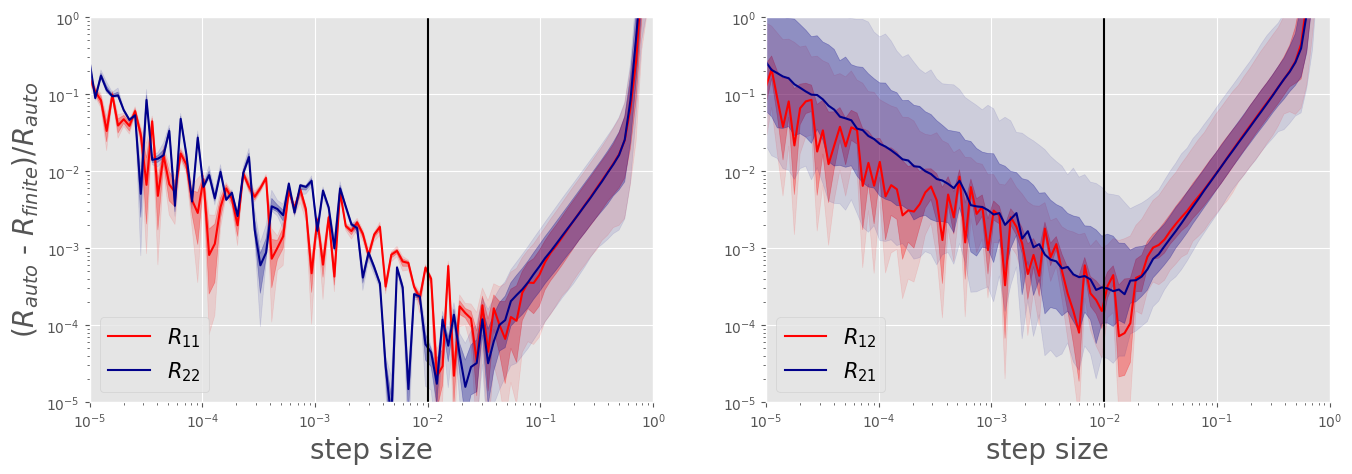

In [57]:
style.use('ggplot')
figure(figsize=(16,5))
subplot(121)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0])/abs(R_auto[:,0,0]),[95],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0])/abs(R_auto[:,0,0]),[5],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.1)

Yup00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0])/abs(R_auto[:,0,0]),[84],axis=1)[0]
Ydn00  = np.percentile(abs(R_auto[:,0,0]-R_finite[:,:,0,0])/abs(R_auto[:,0,0]),[16],axis=1)[0]
fill_between(steps, Yup00,Ydn00,color='red',alpha=0.3)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1])/abs(R_auto[:,1,1]),[95],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1])/abs(R_auto[:,1,1]),[5],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.1)

Yup11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1])/abs(R_auto[:,1,1]),[84],axis=1)[0]
Ydn11  = np.percentile(abs(R_auto[:,1,1]-R_finite[:,:,1,1])/abs(R_auto[:,1,1]),[16],axis=1)[0]
fill_between(steps, Yup11,Ydn11,color='darkblue',alpha=0.3)


plot(steps,np.median(abs(R_auto[:,0,0]-R_finite[:,:,0,0])/abs(R_auto[:,0,0]),axis=1),label="$R_{11}$",color='red')
plot(steps,np.median(abs(R_auto[:,1,1]-R_finite[:,:,1,1])/abs(R_auto[:,1,1]),axis=1),label="$R_{22}$",color='darkblue')

plot([1e-2,1e-2],[1e-5,1e-0],'k-')
ylim([1e-5,1e0])
xlim([1e-5,1e0])
xlabel('step size',fontsize=20)
ylabel('$(R_{auto}$ - $R_{finite})/R_{auto}$',fontsize=20)
legend(loc=3,fontsize=15)
xscale('log')
yscale('log')

subplot(122)

####CL95
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0])/abs(R_auto[:,1,0]),[95],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0])/abs(R_auto[:,1,0]),[5],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.1)
####CL68
Yup10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0])/abs(R_auto[:,1,0]),[84],axis=1)[0]
Ydn10  = np.percentile(abs(R_auto[:,1,0]-R_finite[:,:,1,0])/abs(R_auto[:,1,0]),[16],axis=1)[0]
fill_between(steps, Yup10,Ydn10,color='red',alpha=0.3)


Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1])/abs(R_auto[:,0,1]),[95],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1])/abs(R_auto[:,0,1]),[5],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.1)

Yup01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1])/abs(R_auto[:,0,1]),[84],axis=1)[0]
Ydn01  = np.percentile(abs(R_auto[:,0,1]-R_finite[:,:,0,1])/abs(R_auto[:,0,1]),[16],axis=1)[0]
fill_between(steps, Yup01,Ydn01,color='darkblue',alpha=0.3)

plot(steps,(np.median(abs(R_auto[:,1,0]-R_finite[:,:,1,0])/abs(R_auto[:,1,0]),axis=1)),label="$R_{12}$",color='red')
plot(steps,(np.median(abs(R_auto[:,0,1]-R_finite[:,:,0,1])/abs(R_auto[:,0,1]),axis=1)),label="$R_{21}$",color='darkblue')
plot([1e-2,1e-2],[1e-5,1e-0],'k-')
ylim([1e-5,1e0])
xlim([1e-5,1e0])
xlabel('step size',fontsize=20)

legend(loc=3,fontsize=15)
xscale('log')
yscale('log')
savefig('median_response_high_snr.pdf',bbox_inches='tight')